<a href="https://colab.research.google.com/github/Fremiud/Proyect2-AI/blob/main/Regression_AI_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import r2_score

# Step 1: Load and preprocess the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()

# One-hot encoding for the 'Origin' column
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0


# Split the dataset (replace train_test_split)
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

# Normalize the dataset (replace StandardScaler)
train_mean = train_dataset.drop('MPG', axis=1).mean()
train_std = train_dataset.drop('MPG', axis=1).std()
scaled_train_data = (train_dataset.drop('MPG', axis=1) - train_mean) / train_std
scaled_test_data = (test_dataset.drop('MPG', axis=1) - train_mean) / train_std

train_features = torch.tensor(scaled_train_data.values, dtype=torch.float32)
train_labels = torch.tensor(train_dataset['MPG'].values, dtype=torch.float32).view(-1, 1)
test_features = torch.tensor(scaled_test_data.values, dtype=torch.float32)
test_labels = torch.tensor(test_dataset['MPG'].values, dtype=torch.float32).view(-1, 1)

# Step 2: Define the neural network models
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc = nn.Linear(9, 1)

    def forward(self, x):
        return self.fc(x)

class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1 = nn.Linear(9, 10, bias=True)
        self.fc2 = nn.Linear(10, 20,bias=True)
        self.fc3 = nn.Linear(20, 10,bias=True)
        self.fc4 = nn.Linear(10, 1,bias=True)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

class Network3(nn.Module):
    def __init__(self):
        super(Network3, self).__init__()
        self.fc1 = nn.Linear(9, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 30)
        self.fc4 = nn.Linear(30, 20)
        self.fc5 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return  self.fc5(x)

# Step 3: Train the models
def train_model(model, train_features, train_labels, test_features, test_labels, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    
    train_losses = []
    test_losses = []

    # Print table header
    print(f'{"Epoch":<6}{"Train Loss":<12}{"Test Loss":<12}')
    print("-" * 30)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model.forward(train_features)

        loss = criterion(predictions, train_labels)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
               
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_predictions = model(test_features)
            test_loss = criterion(test_predictions, test_labels)
            test_losses.append(test_loss.item())

        if (epoch + 1) % 5 == 0:
            # Print losses in tabular format
            print(f'{epoch + 1:<6}{loss.item():<12.4f}{test_loss.item():<12.4f}')

    r2 = r2_score(test_labels.numpy(), test_predictions.numpy())
    
    return train_losses, test_losses, 0

In [10]:
# [Optional] Set the random seed for PyTorch and NumPy
# torch.manual_seed(5649665367228949740)

# Train and evaluate each network
epochs = 20
learning_rate = 0.01

print("Network #1")
model1 = Network1()
train_losses1, test_losses1, r2_score1 = train_model(model1, train_features, train_labels, test_features, test_labels, epochs, learning_rate)
print(f'R^2 Score: {r2_score1:.4f}')

print("\nNetwork #2")
model2 = Network2()
train_losses2, test_losses2, r2_score2 = train_model(model2, train_features, train_labels, test_features, test_labels, epochs, learning_rate)
print(f'R^2 Score: {r2_score2:.4f}')

print("\nNetwork #3")
model3 = Network3()
train_losses3, test_losses3, r2_score3 = train_model(model3, train_features, train_labels, test_features, test_labels, epochs, learning_rate)
print(f'R^2 Score: {r2_score3:.4f}')

print("\n")
print(train_losses1[len(train_losses1)-1])
print(train_losses2[len(train_losses2)-1])
print(train_losses3[len(train_losses3)-1])


Network #1


'Epoch Train Loss  Test Loss   '

------------------------------
5     502.9442    525.9538    
10    405.3165    421.1949    
15    330.9851    342.1707    
20    272.0728    280.3828    
R^2 Score: 0.0000

Network #2


'Epoch Train Loss  Test Loss   '

------------------------------
5     157.6165    3671.5144   
10    499.5884    536.7086    
15    372.5159    359.3930    
20    215.9335    161.3225    
R^2 Score: 0.0000

Network #3


'Epoch Train Loss  Test Loss   '

------------------------------
5     337.1778    629.0686    
10    466.0888    491.8340    
15    432.6508    469.5410    
20    364.7776    399.0306    
R^2 Score: 0.0000


272.07281494140625
215.9334716796875
364.777587890625


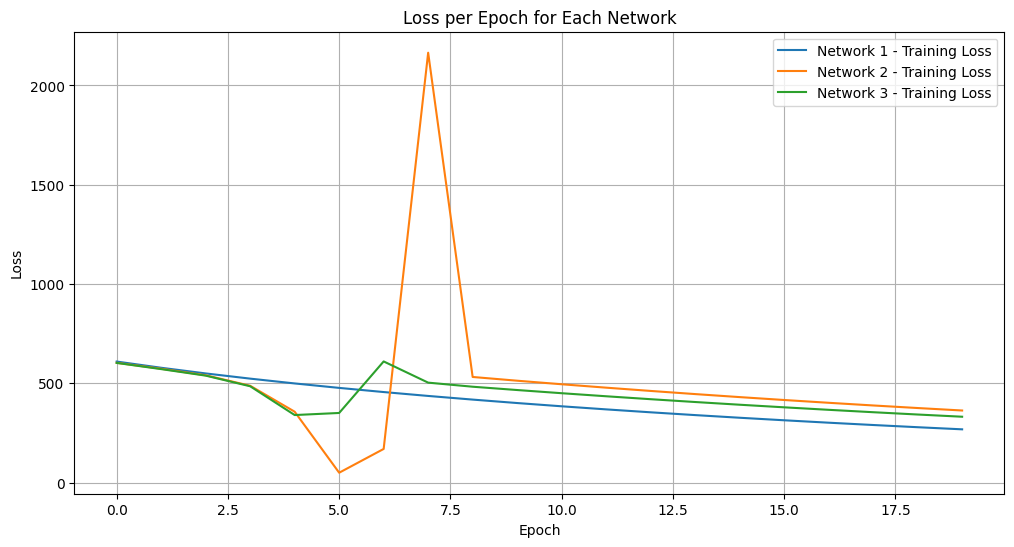

In [8]:
#@title Loss Graph Result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training losses
plt.plot(train_losses1, label='Network 1 - Training Loss')
plt.plot(train_losses2, label='Network 2 - Training Loss')
plt.plot(train_losses3, label='Network 3 - Training Loss')

# Plot test losses
# plt.plot(test_losses1, linestyle='--', label='Network 1 - Test Loss')
# plt.plot(test_losses2, linestyle='--', label='Network 2 - Test Loss')
# plt.plot(test_losses3, linestyle='--', label='Network 3 - Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch for Each Network')
plt.grid(True)
plt.show()


In [133]:
import torch

# Get the current random seed for PyTorch
current_seed = torch.initial_seed()

# Print the current random seed
print("Current PyTorch random seed:", current_seed)


Current PyTorch random seed: 14954364539899969302
